In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def feature_squeeze(x, bit_depth=5):
    """Reduce the bit-depth of the input image."""
    max_val = torch.tensor(2**bit_depth - 1).to(x.device)
    x = torch.round(x * max_val) / max_val 
    return x


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = ResidualBlock(64, 128, stride=2)
        self.layer2 = ResidualBlock(128, 256, stride=2)
        self.layer3 = ResidualBlock(256, 512, stride=2)

        self.dropout = nn.Dropout(0.3)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = feature_squeeze(x)  # Apply feature squeezing before passing through the model
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)

In [2]:
import torchvision.transforms as transforms
import numpy as np
import cv2

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

In [3]:
import torch
import torchvision
train = torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform_train)
test = torchvision.datasets.CIFAR10(root='./data',train=False,download=False,transform=transform_test)
trainloader = torch.utils.data.DataLoader(train,batch_size=128,shuffle=True)
testloader = torch.utils.data.DataLoader(test,batch_size=128,shuffle=False)

100%|██████████| 170M/170M [00:15<00:00, 11.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [4]:
model = CNN()

In [5]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

device = "cuda"
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
model = model.to(device)
from tqdm import tqdm

lr = 0.001
for i in range(20):
    correct, total, running_loss = 0, 0, 0
    train_bar = tqdm(trainloader, desc=f'Train Epoch {i}')

    for image, label in train_bar:
        image, label = image.to(device), label.to(device)

        out = model(image)
        loss_value = loss(out, label)

        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

        predictions = out.argmax(dim=1)
        correct += (predictions == label).sum().item()
        total += label.size(0)
        running_loss += loss_value.item()

        train_bar.set_postfix(loss=running_loss / total, acc=100 * correct / total)
        writer.add_scalar('Loss/train', running_loss / total, i)    
        writer.add_scalar('Accuracy/train', 100 * correct / total, i)
    correct, total, test_loss = 0, 0, 0
    test_bar = tqdm(testloader, desc=f'Test Epoch {i}')

    with torch.no_grad():
        for test, test_label in test_bar:
            test, test_label = test.to(device), test_label.to(device)

            test_out = model(test)
            loss_value = loss(test_out, test_label)
            test_loss += loss_value.item()

            predictions = test_out.argmax(dim=1)
            correct += (predictions == test_label).sum().item()
            total += test_label.size(0)

            test_bar.set_postfix(loss=test_loss / total, acc=100 * correct / total)
            writer.add_scalar('Loss/test', test_loss / total, i)
            writer.add_scalar('Accuracy/test', 100 * correct / total, i)
    scheduler.step(test_loss)
    if optimizer.param_groups[0]["lr"] != lr:
        lr = optimizer.param_groups[0]["lr"]
        print(f"Updated learning rate: {lr}")

Test Epoch 19: 100%|██████████| 79/79 [00:03<00:00, 24.74it/s, acc=85, loss=0.00357]


In [6]:
torch.save(model.state_dict(), 'cifar10_cnn_featSqueeze.pth')

In [7]:
import random

target_class = torch.tensor([9], dtype=torch.long, device="cuda") 
model = model.to("cuda")
model.eval()
c = 0
l = 0
input_image = None
for i in range(100):
    j = random.randint(1, len(train))
    input_image = train[j][0].unsqueeze(0).to("cuda")
    input_image = input_image.detach().clone()
    input_image.requires_grad_(True)
    output = model(input_image)
    loss = -torch.nn.functional.cross_entropy(output, target_class)
    
    model.zero_grad()
    loss.backward()
    
    with torch.no_grad():
        input_image += 0.1 * input_image.grad.sign()
        input_image.clamp_(0, 1)
    input_image.grad.zero_()
    a = model(input_image)
    pred = torch.argmax(torch.nn.functional.softmax(a, dim=1)).item()
    if pred == train[j][1]:
        c += 1
    l += loss.item()
print(c / 100)
print("average loss", l / 100)

0.63
average loss -7.641308475948572


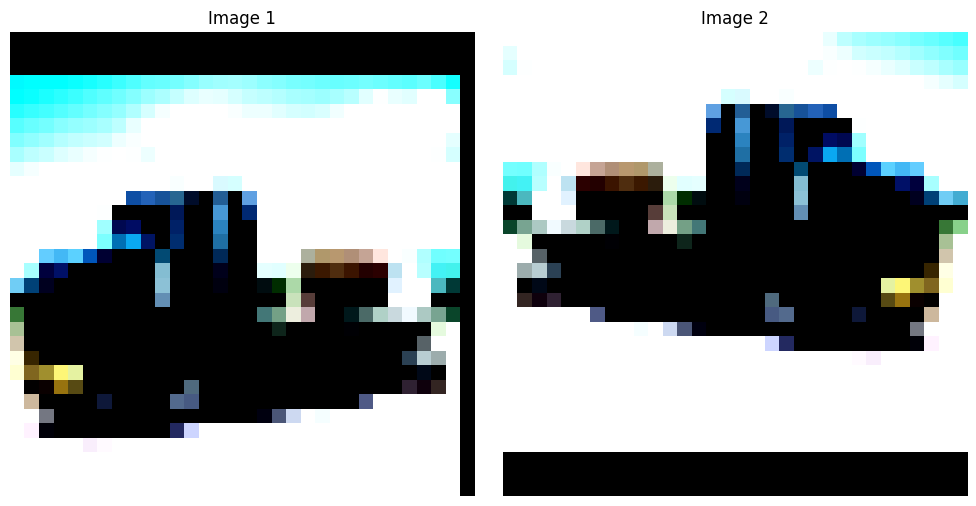

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  
axes[0].imshow(input_image.detach().cpu()[0].permute(1, 2, 0).numpy())
axes[0].axis('off')  
axes[0].set_title("Image 1")

axes[1].imshow(np.transpose(train[j][0], (1, 2, 0)))
axes[1].axis('off')  
axes[1].set_title("Image 2")

# Show the plot
plt.tight_layout()
plt.show()

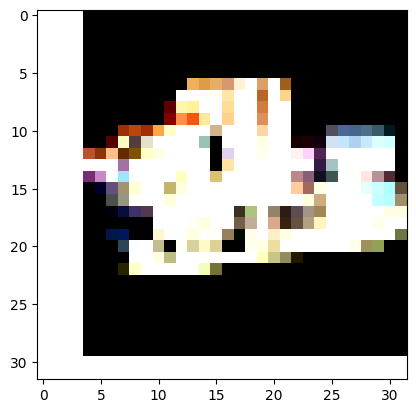

In [9]:
plt.imshow(input_image.detach().cpu()[0].permute(1, 2, 0) - np.transpose(train[j][0], (1, 2, 0)))
plt.show()